# 0. The problem

### Context

Our client is an Insurance company that has provided Health Insurance to its customers. Now the company needs your help to build a model capable of predict if a policyholder (customers) from past year will also be interested in **Vehicle Insurance**, also provided by the company.

A prediction model will help the company being more accurate in its communication strategy to reach out those customers most likely to purchase a vehicle insurance.

### Solution

Supposing that the company does not have enough resources to contact every client in the data base, a good strategy would be creating a list of clients ordered by their propensity of being interested in Vehicle Insurance. Such strategy would allow the company to maximize the effort of reaching the potential clients in comparison to a randomized choice in a list.

Let's say the company has a marketing budget to contact **25000** person.

The purpose is to employ a Machine Learning model to order a list of clients, from the most interested in to the less one. Next, with that list it is possible to plot a Cumulative Gains Curve to evaluate the effectiveness of the model in comparison to a randomized choice.

# 1. Data description

## 1.1. Imports

In [2]:
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, QuantileTransformer, PowerTransformer, RobustScaler
from sklearn.feature_selection import mutual_info_classif

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score
import scikitplot as skplt

## 1.2. Loading data

In [3]:
PATH = '/home/ezequiel/Documentos/Comunidade_DS/car_insurance_sell/data/raw/train.csv'

df_raw = pd.read_csv(filepath_or_buffer=PATH)
df_train = df_raw.copy()

# 2. Exploratory Data Analysis (EDA)

## 2.1. Data description

In [4]:
df_train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


Columns description:

* **id**                      Unique ID for the customer  
* **Gender**                  Gender of the customer  
* **Age**                     Age of the customer  
* **Driving_License**         0 : Customer does not have DL, 1 : Customer already has DL  
* **Region_Code** 	        Unique code for the region of the customer  
* **Previously_Insured**	    1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance  
* **Vehicle_Age** 	        Age of the Vehicle  
* **Vehicle_Damage** 	        1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.  
* **Annual_Premium** 	        The amount customer needs to pay as premium in the year  
* **Policy_Sales_Channel** 	Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.  
* **Vintage** 	            Number of Days which customer has been associated with the company  
* **Response** 	            1 : Customer is interested, 0 : Customer is not interested

* Currency: Idian Rupee (Rs)

In [5]:
#df_train.columns = df_train.columns.str.lower()

#### Shape

In [6]:
print(f'Number of rows: {df_train.shape[0]}')
print(f'Number of columns: {df_train.shape[1]}')

Number of rows: 381109
Number of columns: 12


In [7]:
## id column has no importance and can be removed
#df_train.drop(columns=['id'], inplace=True)

#### Types

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


#### Missing values
-> No missing values

In [9]:
df_train.isna().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

#### Duplicated
-> The number of duplicates is low, so they were removed with no further investigation

In [10]:
df_train.duplicated().sum()

0

In [11]:
#df_train.drop_duplicates(inplace=True)

#### Target variable
-> Unbalanced target

<Axes: xlabel='Response', ylabel='count'>

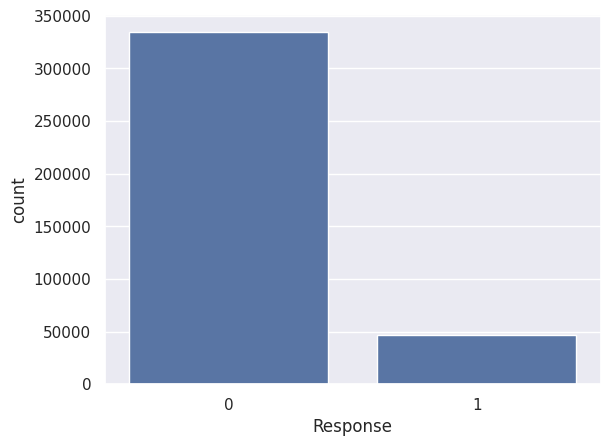

In [12]:
sns.countplot(data=df_train, x=df_train['Response'])

In [13]:
print(f'Total of interested: {df_train["Response"].value_counts(normalize=True)[1]*100:.2f}%')
print(f'Total of not interested: {df_train["Response"].value_counts(normalize=True)[0]*100:.2f}%')

Total of interested: 12.26%
Total of not interested: 87.74%


#### Numerical variables

In [14]:
num_columns = df_train.select_dtypes(exclude='object').columns.tolist()
num_columns.pop(0)
num_columns

['Age',
 'Driving_License',
 'Region_Code',
 'Previously_Insured',
 'Annual_Premium',
 'Policy_Sales_Channel',
 'Vintage',
 'Response']

In [15]:
df_train[num_columns].describe()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


**Summary**
- Some numerical variables are representing cattegorical variables:
    - driving license
    - previously insured
    - region code
    - policy sales channel
    - response
- Variable representing numerical variables:
    - age
    - annual premium
    - vintage

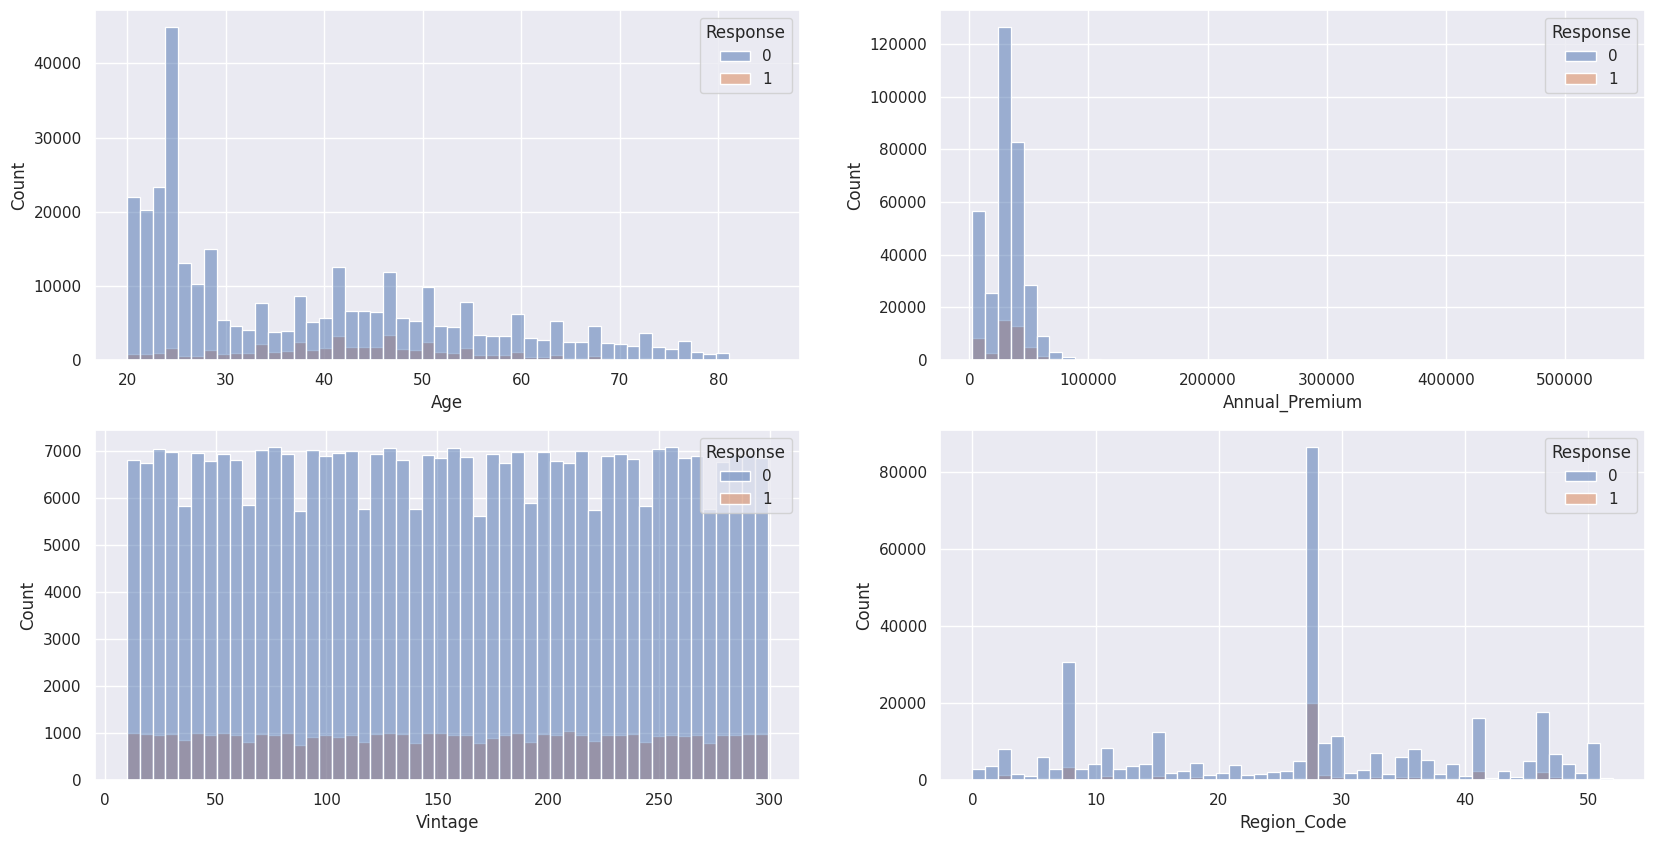

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
sns.histplot(data=df_train, x='Age', hue='Response', bins=50, ax=ax[0][0])
sns.histplot(data=df_train, x='Annual_Premium', bins=50, hue='Response', ax=ax[0][1])
sns.histplot(data=df_train, x='Vintage', hue='Response', bins=50, ax=ax[1][0])
sns.histplot(data=df_train, x='Region_Code', hue='Response', bins=50, ax=ax[1][1]);

#### Categorical variables

In [17]:
cat_columns = df_train.select_dtypes(include='object').columns.tolist()
cat_columns

['Gender', 'Vehicle_Age', 'Vehicle_Damage']

<Axes: xlabel='Driving_License', ylabel='count'>

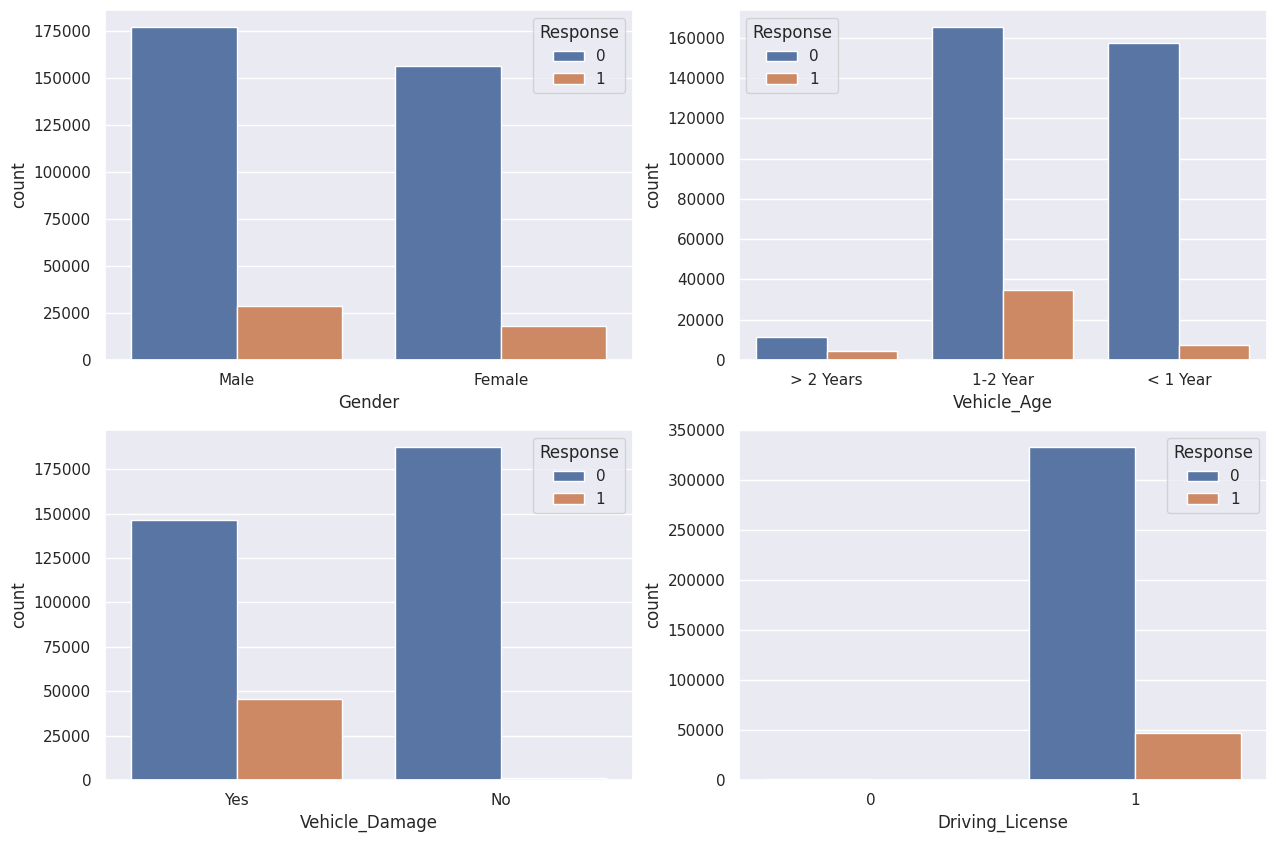

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
sns.countplot(data=df_train, x='Gender', hue='Response', ax=ax[0][0])
sns.countplot(data=df_train, x='Vehicle_Age', hue='Response', ax=ax[0][1])
sns.countplot(data=df_train, x='Vehicle_Damage', hue='Response', ax=ax[1][0])
sns.countplot(data=df_train, x='Driving_License', hue='Response', ax=ax[1][1])

## 2.2. Hypothesis

#### **H1**: Individuals between 30 and 50 years old would be more likely to purchase a vehicle insurance.
-> True

In [19]:
between_30_50 = df_train.query('Age >= 30 & Age <= 50 & Response == 1').shape[0]
below_30 = df_train.query('Age < 30 and Response == 1').shape[0]
over_50 = df_train.query('Age > 50 and Response == 1').shape[0]

In [20]:
aux1 = pd.DataFrame({'below_30': [below_30],
                     'between_30_50': [between_30_50],
                     'over_50': [over_50]})
aux1

,below_30,between_30_50,over_50
0,6374,28431,11905


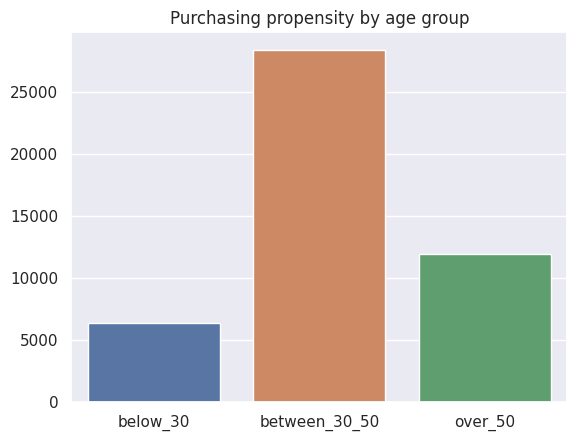

In [21]:
sns.barplot(data=aux1)
plt.title('Purchasing propensity by age group');

#### **H2**: Women would be more interested in having vehicle insurance.
-> False. 10,4% of total women would purchase compared to 13,8% of total men.

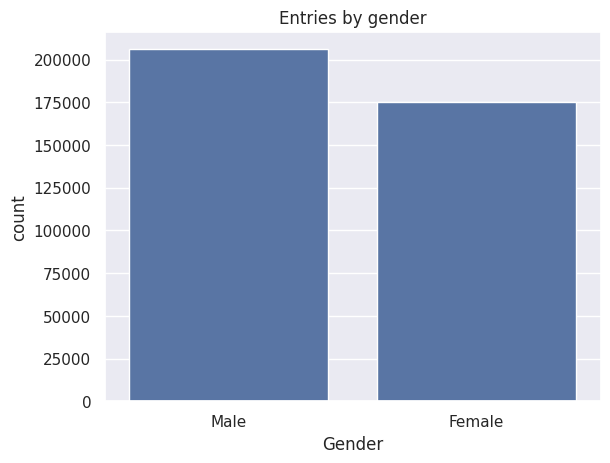

In [22]:
sns.countplot(data=df_train, x='Gender')
plt.title('Entries by gender');

In [23]:
# Result given in proportion by gender
gender_count = pd.crosstab(df_train['Response'], df_train['Gender'], normalize='columns')
gender_count

Gender,Female,Male
Response,,
0,0.896098,0.861589
1,0.103902,0.138411


Text(0.5, 1.0, 'Interest by gender')

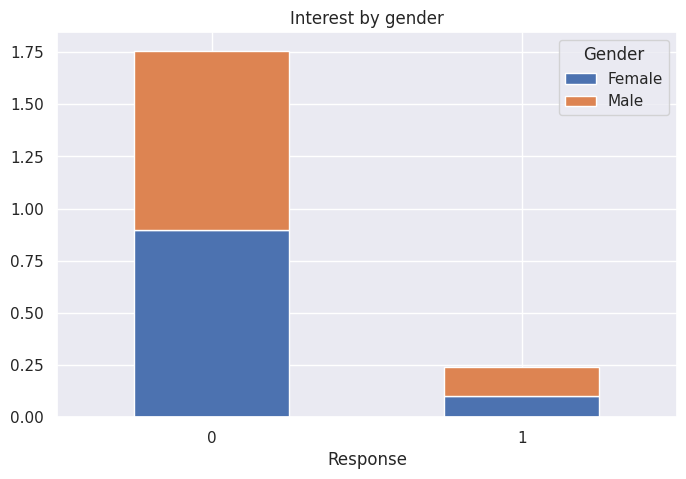

In [24]:
fig, ax = plt.subplots(figsize=(8,5))
gender_count.plot(kind='bar', stacked=True, ax=ax)
plt.xticks(rotation=0)
plt.title('Interest by gender')

#### **H3**: Individuals who already have driver license and got the vehicle damage in the past would be more interested in vehicle insurance.
-> False.

In [25]:
aux3 = df_train.query('Driving_License == 1 & Vehicle_Damage == "Yes"')['Response'].value_counts()

Text(0.5, 1.0, 'Purchasing propensity among people who Driving_License = 1 and Vehicle_Damage = Yes')

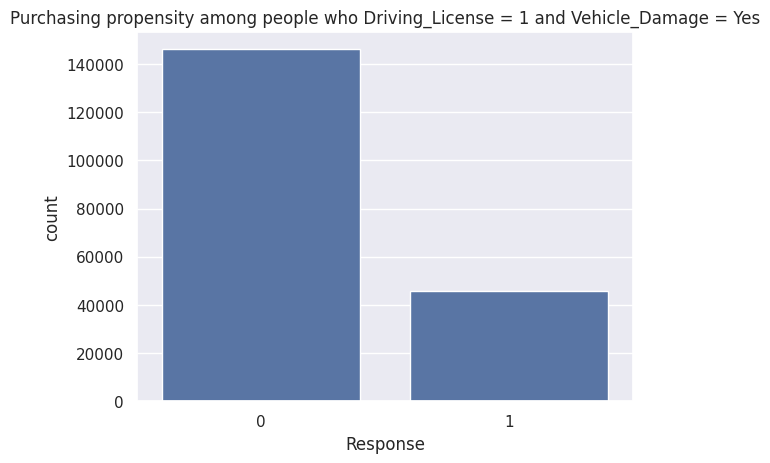

In [26]:
sns.barplot(data=aux3)
plt.title('Purchasing propensity among people who Driving_License = 1 and Vehicle_Damage = Yes')

#### **H4**: Individuals who already have vehicle insurance (previously insured) would not be interested in vehicle insurance.
-> True. 99,91% of those who already have insurance would not purchase another one

In [27]:
pd.crosstab(index=df_train['Response'], columns=df_train['Previously_Insured'], normalize='columns')

Previously_Insured,0,1
Response,,
0,0.774546,0.999095
1,0.225454,0.000905


#### **H5**: Individuals who got the vehicle damaged and were not previously insured would be more interested in vehicle insurance.
-> False. Even if not being insured, people who have vehicle damaged would not purschase

<Axes: xlabel='Response', ylabel='count'>

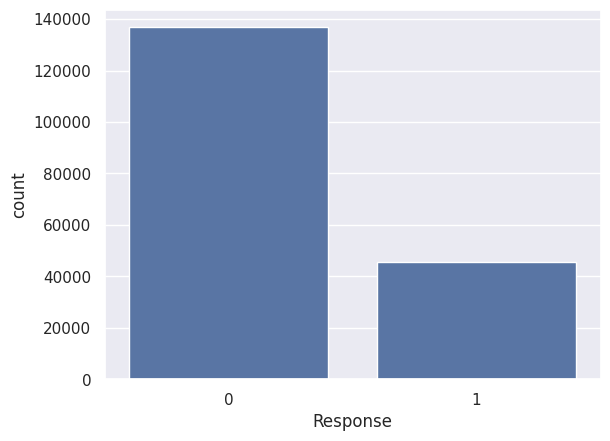

In [28]:
aux5 = df_train.query('Vehicle_Damage == "Yes" & Previously_Insured == 0')['Response'].value_counts()
sns.barplot(data=aux5)

#### **H6**: Individuals who own vehicle with more than two year would be more interested in vehicle insurance.
-> FALSE. Ownners of vehicles between 1-2 years are the most interested.

In [29]:
aux7 = pd.crosstab(index=df_train['Response'], columns=df_train['Vehicle_Age'])
aux7

Vehicle_Age,1-2 Year,< 1 Year,> 2 Years
Response,,,
0,165510,157584,11305
1,34806,7202,4702


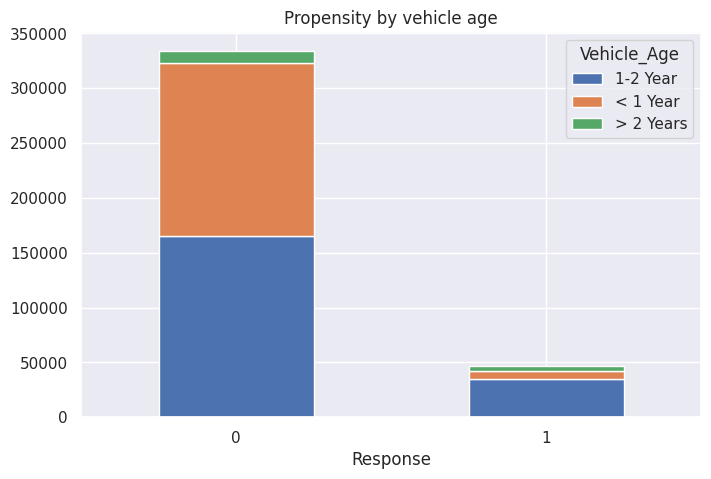

In [30]:
fig, ax = plt.subplots(figsize=(8,5))
aux7.plot(kind='bar', stacked=True, ax=ax)
plt.xticks(rotation=0)
plt.title('Propensity by vehicle age');

<Axes: xlabel='Vehicle_Damage', ylabel='count'>

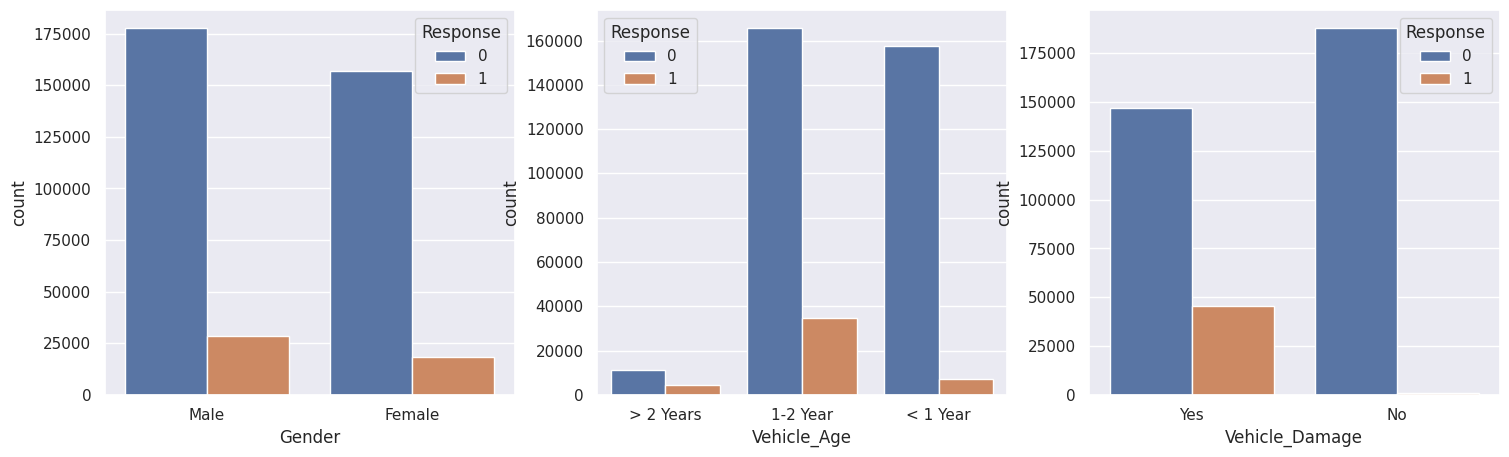

In [31]:
fig, ax = plt.subplots(1,3, figsize=(18,5))
sns.countplot(data=df_train, x=df_train['Gender'], hue=df_train['Response'], ax=ax[0])
sns.countplot(data=df_train, x=df_train['Vehicle_Age'], hue=df_train['Response'], ax=ax[1])
sns.countplot(data=df_train, x=df_train['Vehicle_Damage'], hue=df_train['Response'], ax=ax[2])

#### Vehicle Damage = No --> almost everybody is not interested 

# 3. Feature Engineering

## 3.1. Spliting features from target variable

In [32]:
X_train = df_train.drop(columns='Response').copy()

y_train = df_train['Response']

## 3.2. Data preparation

In [33]:
# Make column names lowercase
X_train.columns = X_train.columns.str.lower()
y_train.name = y_train.name.lower()

In [34]:
# id column has no importance and can be removed
X_train.drop(columns=['id'], inplace=True)

In [35]:
# Rewrite vehicle age
age_dict = {'1-2 Year': 'between_1_2',
            '< 1 Year': 'below_1',
            '> 2 Years': 'over_2'}
X_train['vehicle_age'] = X_train['vehicle_age'].map(age_dict)

In [36]:
num_columns = X_train.select_dtypes(exclude='object').columns.to_list()
cat_columns = X_train.select_dtypes(include='object').columns.to_list()

In [37]:
#df_train.dropna(inplace=True)
#df_train.drop_duplicates(inplace=True)

In [38]:
## Transform vehicle_damage to numeric
#df_train['vehicle_damage'] = df_train['vehicle_damage'].apply(lambda x: 0 if x=='No' else 1)

## 3.2. Feature importance

### 3.2.1. Mutual information

Mutual information describes relationships in terms of uncertainty. The mutual information (MI) between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other. If you knew the value of a feature, how much more confident would you be about the target?

What we're calling uncertainty is measured using a quantity from information theory known as "entropy". The entropy of a variable means roughly: "how many yes-or-no questions you would need to describe an occurance of that variable, on average." The more questions you have to ask, the more uncertain you must be about the variable. Mutual information is how many questions you expect the feature to answer about the target.

In [39]:
cat_columns

['gender', 'vehicle_age', 'vehicle_damage']

In [40]:
X_feat_imp = X_train.copy()
y_feat_imp = y_train.copy()

In [41]:
for col in cat_columns:
    X_feat_imp[col], _ = X_feat_imp[col].factorize()

In [42]:
for col in num_columns:
    X_feat_imp[col] = X_feat_imp[col].astype('int64')

In [43]:
X_feat_imp.head()

,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage
0,0,44,1,28,0,0,0,40454,26,217
1,0,76,1,3,0,1,1,33536,26,183
2,0,47,1,28,0,0,0,38294,26,27
3,0,21,1,11,1,2,1,28619,152,203
4,1,29,1,41,1,2,1,27496,152,39


In [44]:
mi_score = mutual_info_classif(X=X_feat_imp, y=y_feat_imp, n_jobs=3)

In [45]:
mi_score = pd.Series(data=mi_score, index=X_feat_imp.columns).sort_values(ascending=False)

In [46]:
mi_score

vehicle_damage          0.140727
previously_insured      0.132529
driving_license         0.073230
policy_sales_channel    0.057013
vehicle_age             0.053442
gender                  0.045258
age                     0.030773
region_code             0.016988
annual_premium          0.003104
vintage                 0.000992
dtype: float64

In [47]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

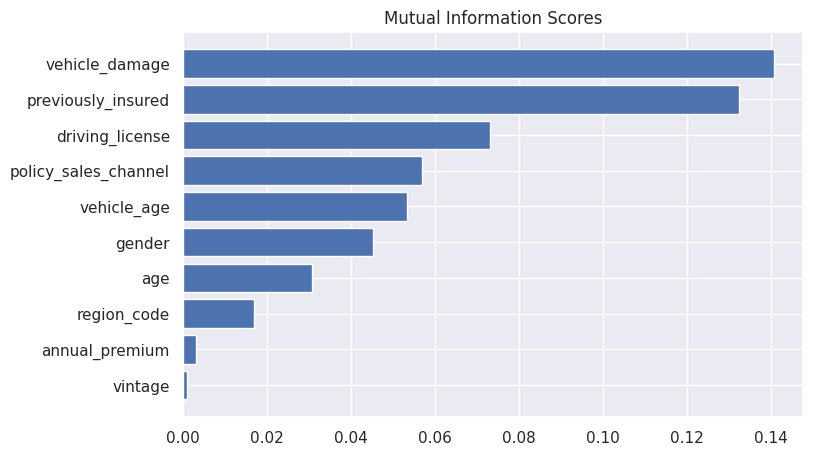

In [48]:
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_score)

### 3.2.2. Tree-based

In [67]:
rf_select = RandomForestClassifier(n_estimators=150)

rf_select.fit(X=X_feat_imp, y=y_feat_imp)

RandomForestClassifier(n_estimators=150)

<Axes: title={'center': 'Feature Importance'}>

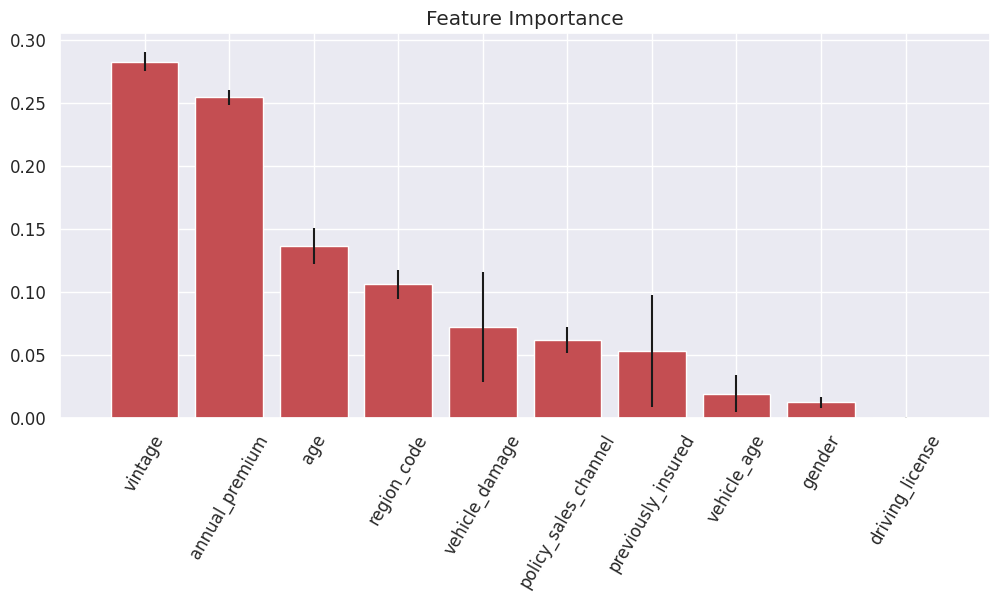

In [68]:
skplt.estimators.plot_feature_importances(clf=rf_select, feature_names=X_feat_imp.columns, figsize=(12,5), x_tick_rotation=60)

In [59]:
df = X_train.join(y_train)

In [60]:
X_train

,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage
0,Male,44,1,28.0,0,over_2,Yes,40454.0,26.0,217
1,Male,76,1,3.0,0,between_1_2,No,33536.0,26.0,183
2,Male,47,1,28.0,0,over_2,Yes,38294.0,26.0,27
3,Male,21,1,11.0,1,below_1,No,28619.0,152.0,203
4,Female,29,1,41.0,1,below_1,No,27496.0,152.0,39
...,...,...,...,...,...,...,...,...,...,...
381104,Male,74,1,26.0,1,between_1_2,No,30170.0,26.0,88
381105,Male,30,1,37.0,1,below_1,No,40016.0,152.0,131
381106,Male,21,1,30.0,1,below_1,No,35118.0,160.0,161
381107,Female,68,1,14.0,0,over_2,Yes,44617.0,124.0,74


In [62]:
df.groupby(['gender', 'vehicle_damage'])['response'].value_counts()

gender  vehicle_damage  response
Female  No              0           94937
                        1             418
        Yes             0           61898
                        1           17767
Male    No              0           92777
                        1             564
        Yes             0           84787
                        1           27961
Name: count, dtype: int64

<Axes: xlabel='vehicle_damage', ylabel='count'>

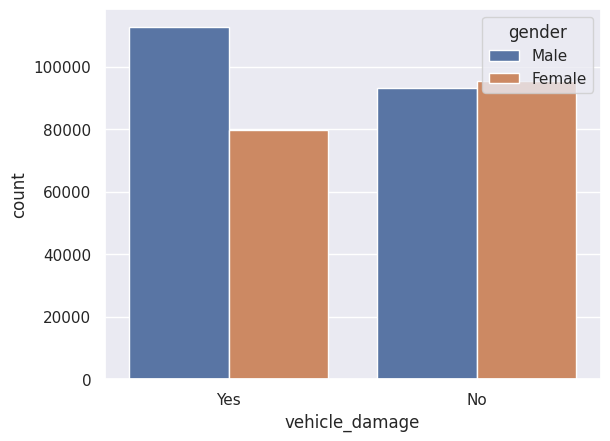

In [52]:
sns.countplot(data=X_train, x='vehicle_damage', hue='gender')

# 4. Machine Learning Modeling

## 4.2. Pipeline

In [ ]:
num_columns_pipeline = ['age', 'region_code', 'annual_premium', 'policy_sales_channel', 'vintage']
cat_columns_pipeline = cat_columns

In [ ]:
num_pipeline = Pipeline(steps=[
                        ('num_std', StandardScaler())
                        #('num_mms', MinMaxScaler())
                        ])

In [ ]:
cat_pipeline = Pipeline(steps=[
                        ('cat_ohe', OneHotEncoder())
                        ])

In [ ]:
preprocessor = ColumnTransformer(transformers=[
                                ('num', num_pipeline, num_columns_pipeline),
                                ('cat', cat_pipeline, cat_columns_pipeline)
])

## 4.3. Model trainning

### 4.3.1. KNN

In [ ]:
knn_clf = KNeighborsClassifier()

In [ ]:
knn_model = Pipeline(steps=[
                    ('preprocess', preprocessor),
                    ('model', knn_clf)
                    ])

In [ ]:
knn_predict = cross_val_predict(estimator=knn_model, X=X_train, y=y_train, cv=2)

In [ ]:
skplt.metrics.plot_confusion_matrix(y_pred=knn_predict, y_true=y_train, normalize=False);

In [97]:
def some_metrics(y_pred, y_true):
    precision = precision_score(y_pred=y_pred, y_true=y_true)
    recall = recall_score(y_pred=y_pred, y_true=y_true)
    f1 = f1_score(y_pred=y_pred, y_true=y_true)
    print(f'Precision: {100*precision:.4f}%')
    print(f'Recall: {100*recall:.4f}%')
    print(f'F1 score: {f1:.4f}')

In [ ]:
some_metrics(knn_predict, y_train)

### 4.3.2. Random Forest

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=100, n_jobs=2, random_state=42)

In [ ]:
rf_model = Pipeline(steps=[
                    ('preprocess', preprocessor),
                    ('model', rf_clf)
                    ])

In [ ]:
rf_predict = cross_val_predict(estimator=rf_model, X=X_train, y=y_train, cv=2)

In [ ]:
skplt.metrics.plot_confusion_matrix(y_pred=rf_predict, y_true=y_train, normalize=True);

In [ ]:
some_metrics(rf_predict, y_train)

### 4.3.3. HGBoosting

In [ ]:
hgb_clf = HistGradientBoostingClassifier(random_state=42)

In [ ]:
hgb_model = Pipeline(steps=[
                    ('preprocess', preprocessor),
                    ('model', hgb_clf)
                    ])

In [ ]:
hgb_predict = cross_val_predict(estimator=hgb_model, X=X_train, y=y_train, cv=2)

In [ ]:
skplt.metrics.plot_confusion_matrix(y_pred=hgb_predict, y_true=y_train, normalize=True);

In [ ]:
some_metrics(hgb_predict, y_train)

## 4.2. Encoding

- Transform categorical attributes to numerical ones

In [ ]:
#encoding_vehicle_age = OneHotEncoder()
#
#new_vehicle_age = encoding_vehicle_age.fit_transform(X_train[['vehicle_age']]).toarray()
#X_train[encoding_vehicle_age.get_feature_names_out()] = new_vehicle_age
#X_train.drop(columns=encoding_vehicle_age.feature_names_in_[0], inplace=True)

In [69]:
# General function for One Hot Encoder
def one_hot_encoder(df_to_encode, feature_to_encode):
    encoder = OneHotEncoder()
    new_features = encoder.fit_transform(df_to_encode[feature_to_encode]).toarray()
    df_to_encode[encoder.get_feature_names_out()] = new_features
    df_to_encode.drop(columns=encoder.feature_names_in_[0], inplace=True)
    return df_to_encode, encoder

In [70]:
# Gender ---> OBS: Test dummy encoding
X_train, encoding_gender = one_hot_encoder(df_to_encode=X_train, feature_to_encode=['gender'])

In [71]:
# Driving license
X_train, encoding_license = one_hot_encoder(df_to_encode=X_train, feature_to_encode=['driving_license'])

In [72]:
# Previously insured
X_train, encoding_insured = one_hot_encoder(df_to_encode=X_train, feature_to_encode=['previously_insured'])

In [73]:
# Vehicle damage
X_train, encoding_damage = one_hot_encoder(df_to_encode=X_train, feature_to_encode=['vehicle_damage'])

In [90]:
X_train, encoding_damage = one_hot_encoder(df_to_encode=X_train, feature_to_encode=['vehicle_age'])

In [91]:
X_train

,age,region_code,annual_premium,policy_sales_channel,vintage,gender_Female,gender_Male,driving_license_0,driving_license_1,previously_insured_0,previously_insured_1,vehicle_damage_No,vehicle_damage_Yes,vehicle_age_below_1,vehicle_age_between_1_2,vehicle_age_over_2
0,0.333777,0.121784,0.590239,-1.587234,0.748795,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,2.396751,-1.767879,0.403622,-1.587234,0.342443,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.527181,0.121784,0.535638,-1.587234,-1.521998,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,-1.148985,-1.163187,0.245859,0.737321,0.581474,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
4,-0.633242,1.104409,0.206027,0.737321,-1.378580,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381104,2.267815,-0.029389,0.298374,-1.587234,-0.792954,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
381105,-0.568774,0.802063,0.579406,0.737321,-0.279037,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
381106,-1.148985,0.272958,0.449488,0.884912,0.079509,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
381107,1.881007,-0.936427,0.687703,0.220753,-0.960275,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


## 4.3. Feature transformation

### Vintage - MinMax scaler,Standard scaler, Quantile transform

In [77]:
#std_vintage = MinMaxScaler()
std_vintage = StandardScaler()
#std_vintage = QuantileTransformer()
#std_vintage = PowerTransformer(method='box-cox')
#std_vintage = RobustScaler()

new_vintage = std_vintage.fit_transform(X_train[['vintage']])
X_train['vintage'] = new_vintage

Text(0.5, 1.0, 'Some scalling')

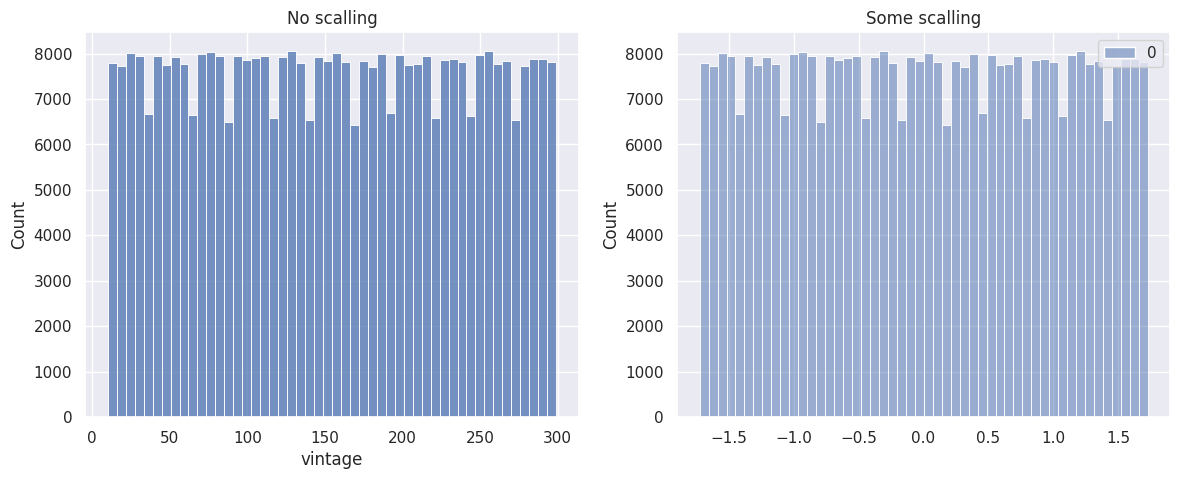

In [76]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
sns.histplot(data=X_train['vintage'], bins=50, ax=ax[0])
sns.histplot(data=new_vintage, bins=50, ax=ax[1])
ax[0].set_title('No scalling')
ax[1].set_title('Some scalling')

### Age - MinMax scaler, Standard scaler, Box-Cox or Quantile transform

In [84]:
#std_age = MinMaxScaler()
std_age = StandardScaler()
#std_age = QuantileTransformer()
#std_age = PowerTransformer(method='box-cox')
#std_age = RobustScaler()

#aux1 = X_train[['age']].transform(np.log1p)
#new_age = std_age.fit_transform(aux1)
new_age = std_age.fit_transform(X_train[['age']])
X_train['age'] = new_age

Text(0.5, 1.0, 'Some scalling')

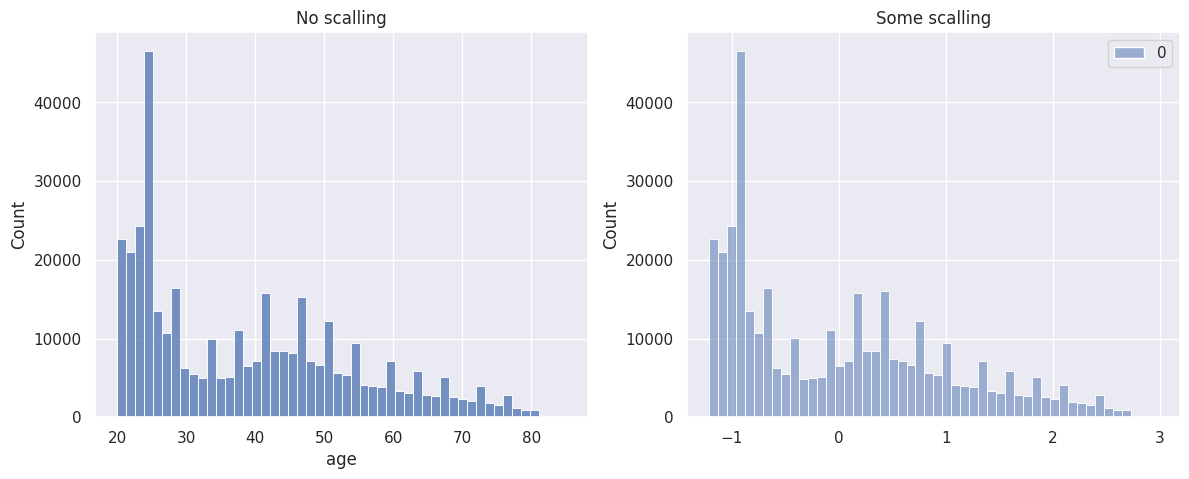

In [83]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
sns.histplot(data=X_train['age'], bins=50, ax=ax[0])
sns.histplot(data=new_age, bins=50, ax=ax[1])
ax[0].set_title('No scalling')
ax[1].set_title('Some scalling')

### Anual premium - Standard scaler, Robust scaler, Box-Cox or Quantile transform

Text(0.5, 1.0, 'Some scalling')

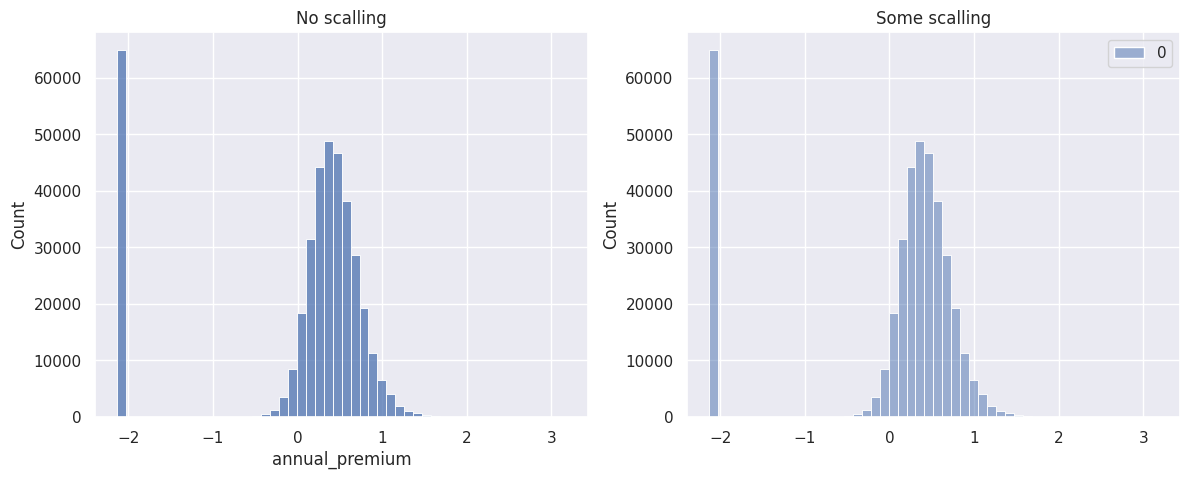

In [85]:
#std_vintage = MinMaxScaler()
std_anual_pr = StandardScaler()
#std_anual_pr = QuantileTransformer()
#std_anual_pr = PowerTransformer(method='box-cox')
#std_anual_pr = RobustScaler()

aux1 = X_train[['annual_premium']].transform(np.log1p)
new_anual_pr = std_anual_pr.fit_transform(aux1)
#new_anual_pr = std_anual_pr.fit_transform(X_train[['annual_premium']])
X_train['annual_premium'] = new_anual_pr

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
sns.histplot(data=X_train['annual_premium'], bins=50, ax=ax[0])
sns.histplot(data=new_anual_pr, bins=50, ax=ax[1])
ax[0].set_title('No scalling')
ax[1].set_title('Some scalling')

### Region code

<Axes: ylabel='Count'>

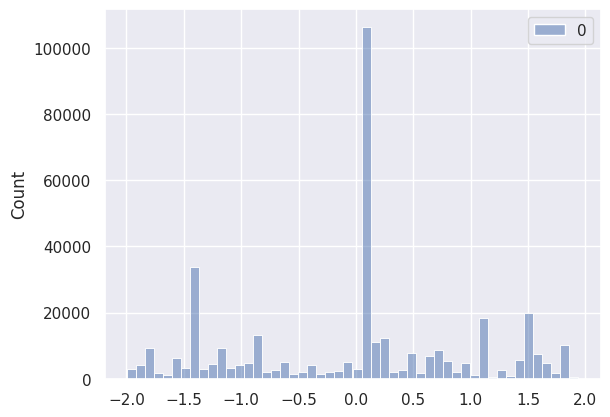

In [86]:
#std_vintage = MinMaxScaler()
std_region_code = StandardScaler()
#std_region_code = QuantileTransformer()
#std_region_code = PowerTransformer(method='yeo-johnson')
#std_region_code = RobustScaler()

new_region_code = std_region_code.fit_transform(X_train[['region_code']])
X_train['region_code'] = new_region_code

sns.histplot(data=new_region_code, bins=50)

### Policy sales channel

<Axes: ylabel='Count'>

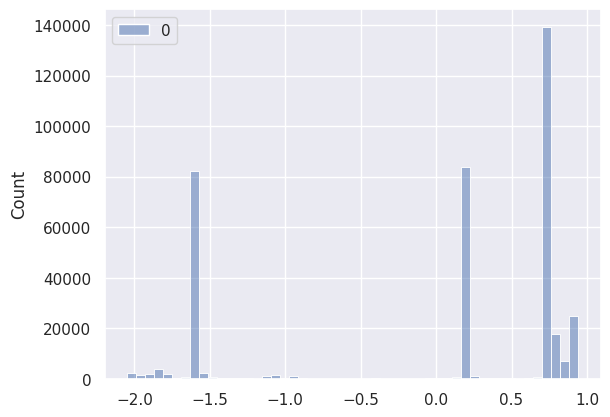

In [87]:
#std_vintage = MinMaxScaler()
std_sales_channel = StandardScaler()
#std_sales_channel = QuantileTransformer()
#std_sales_channel = PowerTransformer(method='yeo-johnson')
#std_sales_channel = RobustScaler()

new_sales_channel = std_sales_channel.fit_transform(X_train[['policy_sales_channel']])
X_train['policy_sales_channel'] = new_sales_channel

sns.histplot(data=new_sales_channel, bins=50)

In [ ]:
X_train.isna().sum()

In [ ]:
#cols_drop = ['1h_ocean', 'inland', 'island', 'near_bay','near_ocean']

df_corr = X_train.join(y_train)

corr_matrix_pe = df_corr.corr(method='pearson')
corr_matrix_sp = df_corr.corr(method='spearman')

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(18,16))
sns.heatmap(data=corr_matrix_pe, annot=True, cmap='seismic', ax=ax[0])
sns.heatmap(data=corr_matrix_sp, annot=True, cmap='seismic', ax=ax[1])

In [89]:
X_train

,age,region_code,vehicle_age,annual_premium,policy_sales_channel,vintage,gender_Female,gender_Male,driving_license_0,driving_license_1,previously_insured_0,previously_insured_1,vehicle_damage_No,vehicle_damage_Yes
0,0.333777,0.121784,over_2,0.590239,-1.587234,0.748795,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
1,2.396751,-1.767879,between_1_2,0.403622,-1.587234,0.342443,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
2,0.527181,0.121784,over_2,0.535638,-1.587234,-1.521998,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
3,-1.148985,-1.163187,below_1,0.245859,0.737321,0.581474,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
4,-0.633242,1.104409,below_1,0.206027,0.737321,-1.378580,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381104,2.267815,-0.029389,between_1_2,0.298374,-1.587234,-0.792954,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
381105,-0.568774,0.802063,below_1,0.579406,0.737321,-0.279037,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
381106,-1.148985,0.272958,below_1,0.449488,0.884912,0.079509,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
381107,1.881007,-0.936427,over_2,0.687703,0.220753,-0.960275,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


In [100]:
mi_score

vehicle_damage          0.140727
previously_insured      0.132529
driving_license         0.073230
policy_sales_channel    0.057013
vehicle_age             0.053442
gender                  0.045258
age                     0.030773
region_code             0.016988
annual_premium          0.003104
vintage                 0.000992
dtype: float64

In [104]:
X_train.columns

Index(['age', 'region_code', 'annual_premium', 'policy_sales_channel',
       'vintage', 'gender_Female', 'gender_Male', 'driving_license_0',
       'driving_license_1', 'previously_insured_0', 'previously_insured_1',
       'vehicle_damage_No', 'vehicle_damage_Yes', 'vehicle_age_below_1',
       'vehicle_age_between_1_2', 'vehicle_age_over_2'],
      dtype='object')

In [111]:
mi_features = ['driving_license_0', 'driving_license_1', 'previously_insured_0', 'previously_insured_1', 'vehicle_damage_No', 'vehicle_damage_Yes', 'vintage']

In [112]:
rf_clf = RandomForestClassifier(n_estimators=100, n_jobs=2, random_state=42)
rf_predict = cross_val_predict(estimator=rf_clf, X=X_train[mi_features], y=y_train, cv=2)

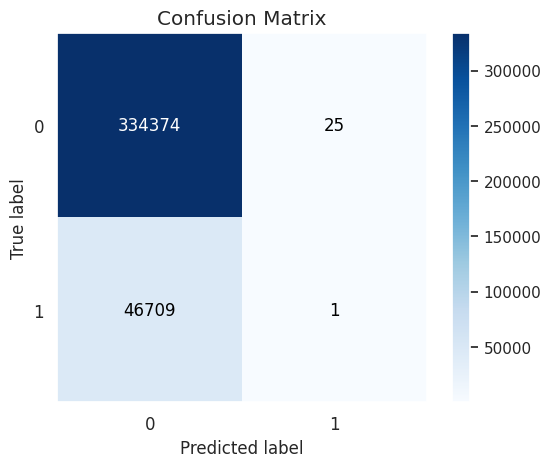

In [113]:
skplt.metrics.plot_confusion_matrix(y_pred=rf_predict, y_true=y_train, normalize=False);

In [114]:
some_metrics(rf_predict, y_train)

Precision: 3.8462%
Recall: 0.0021%
F1 score: 0.0000


In [115]:
X_train[mi_features]

,driving_license_0,driving_license_1,previously_insured_0,previously_insured_1,vehicle_damage_No,vehicle_damage_Yes,vintage
0,0.0,1.0,1.0,0.0,0.0,1.0,0.748795
1,0.0,1.0,1.0,0.0,1.0,0.0,0.342443
2,0.0,1.0,1.0,0.0,0.0,1.0,-1.521998
3,0.0,1.0,0.0,1.0,1.0,0.0,0.581474
4,0.0,1.0,0.0,1.0,1.0,0.0,-1.378580
...,...,...,...,...,...,...,...
381104,0.0,1.0,0.0,1.0,1.0,0.0,-0.792954
381105,0.0,1.0,0.0,1.0,1.0,0.0,-0.279037
381106,0.0,1.0,0.0,1.0,1.0,0.0,0.079509
381107,0.0,1.0,1.0,0.0,0.0,1.0,-0.960275


In [110]:
y_train

0         1
1         0
2         1
3         0
4         0
         ..
381104    0
381105    0
381106    0
381107    0
381108    0
Name: response, Length: 381109, dtype: int64